# DNN 回归

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

## 数据集准备

In [2]:
def create_toy_data(f, sample_size, std=0.25, noise=True):
    x = np.linspace(0, 1, sample_size)
    if noise:
        y = f(x) + np.random.normal(scale=std, size=x.shape)
    else:
        y = f(x)            
    return x, y

In [3]:
def f(x):
    return np.sin(2 * np.pi * x)

In [4]:
x_train, y_train = create_toy_data(f, 100)
x_test , y_test  = create_toy_data(f, 50)
x_exact, y_exact = create_toy_data(f, 100, noise=False)
print(x_train.shape)

(100,)


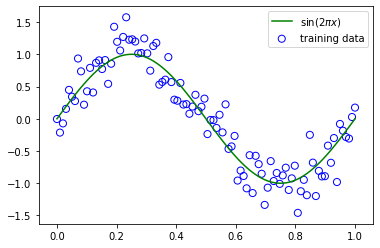

In [61]:
plt.scatter(x_train, y_train, facecolor='none', edgecolors='b', s=50, label='training data')
plt.plot(x_exact, y_exact, c='g', label='$\sin(2\pi x)$')
plt.legend()
plt.show()

In [80]:
class SinDataset(Dataset):
    def __init__(self, f, sample_size=1000):
        super().__init__()
        self.sample_size = sample_size
        self.f = f
        x, y = create_toy_data(self.f, self.sample_size)
        self.x = torch.from_numpy(x).unsqueeze(dim=-1).float()
        self.y = torch.from_numpy(y).unsqueeze(dim=-1).float()
        
    def __len__(self):
        return self.sample_size
    
    def __getitem__(self, index):        
        sample = {'x': self.x[index], 'y': self.y[index]}
        return sample
        

In [93]:
dataset = SinDataset(f, sample_size=10)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)
for i, sample in enumerate(dataloader):
    print(f"{i}: {sample['x']}, {sample['y']}")


0: tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]]), tensor([[ 1.7011e-01],
        [ 7.7012e-01],
        [ 8.1443e-01],
        [ 1.2015e+00],
        [-4.3859e-05],
        [-2.3389e-01],
        [-6.6141e-01],
        [-4.9424e-01],
        [-5.9243e-01],
        [ 1.5841e-01]])


## 神经网络模型

In [99]:
class SimpleNet(nn.Module):
    def __init__(self, layers=[1, 10, 10, 10, 1]):
        super().__init__()
        self.layers = layers
        self.fcs = []
        
        for i in range(len(layers)-1):
            fc = nn.Linear(self.layers[i], self.layers[i+1])
            setattr(self, f'fc{i}', fc)
            self._init_weights(fc)
            self.fcs.append(fc)

    def _init_weights(self, layer):
        nn.init.xavier_normal_(layer.weight)
        nn.init.constant_(layer.bias, 0.01)
                    
    def forward(self, x):
        for i in range(len(self.fcs)-1):
            x = self.fcs[i](x)
            x = torch.tanh(x)
        x = self.fcs[-1](x)
        return x

In [100]:
layers = [1, 10, 10, 10, 1]
model = SimpleNet(layers)
print(model)

SimpleNet(
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


## 训练器

In [150]:
class Trainer(object):
    def __init__(self, layers=[1, 10, 10, 10, 1]):
        self.model = SimpleNet(layers)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.5)
        
        self.trainset = SinDataset(f, sample_size=1000)
        self.trainloader = DataLoader(self.trainset, batch_size=100, shuffle=True)
        self.validset = SinDataset(f, sample_size=100)
        self.validloader = DataLoader(self.validset, batch_size=100, shuffle=False)
        
    def train(self):
        self.model.train()
        best_loss = 1.e10
        losses = []
        epochs = []
        
        for epoch in range(50):
            for _, sample in enumerate(self.trainloader):   
                y_pred = self.model(sample['x'])            
                loss = self.criterion(y_pred, sample['y'])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss = loss.item()
            self.scheduler.step()
            
            epochs.append(epoch)
            losses.append(train_loss)
            if (epoch+1) % 50 == 0:
                valid_loss = self.validate()                
                print(f'epoch: {epoch+1}\ttrain_loss: {train_loss:.4e}\tvalid_loss: {valid_loss:.4e}\tlr: {self.scheduler.get_lr()[0]:.2e}')
                if valid_loss < best_loss:
                    torch.save(self.model.state_dict(), "net.pth")
        plt.plot(epochs, losses, 'r-')
        
    def validate(self):
        self.model.eval()
        for _, sample in enumerate(self.validloader):
            y_pred = self.model(sample['x'])  
            loss = self.criterion(y_pred, sample['y'])
            return loss.item()

epoch: 50	train_loss: 1.0878e-01	valid_loss: 1.2377e-01	lr: 1.00e-03
epoch: 100	train_loss: 5.4257e-02	valid_loss: 7.9684e-02	lr: 5.00e-04
epoch: 150	train_loss: 6.0672e-02	valid_loss: 6.8225e-02	lr: 5.00e-04
epoch: 200	train_loss: 6.4052e-02	valid_loss: 6.1229e-02	lr: 2.50e-04
epoch: 250	train_loss: 7.0237e-02	valid_loss: 5.8907e-02	lr: 2.50e-04
epoch: 300	train_loss: 5.3745e-02	valid_loss: 5.8023e-02	lr: 1.25e-04
epoch: 350	train_loss: 5.0696e-02	valid_loss: 5.7654e-02	lr: 1.25e-04
epoch: 400	train_loss: 6.3105e-02	valid_loss: 5.7433e-02	lr: 6.25e-05
epoch: 450	train_loss: 5.1472e-02	valid_loss: 5.7388e-02	lr: 6.25e-05
epoch: 500	train_loss: 5.2625e-02	valid_loss: 5.7312e-02	lr: 3.13e-05
epoch: 550	train_loss: 6.2503e-02	valid_loss: 5.7239e-02	lr: 3.13e-05
epoch: 600	train_loss: 6.3763e-02	valid_loss: 5.7203e-02	lr: 1.56e-05
epoch: 650	train_loss: 5.8681e-02	valid_loss: 5.7176e-02	lr: 1.56e-05
epoch: 700	train_loss: 6.6562e-02	valid_loss: 5.7164e-02	lr: 7.81e-06
epoch: 750	train_loss

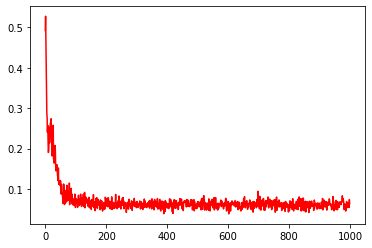

In [151]:
trainer = Trainer()
trainer.train()

## 测试器

In [128]:
class Tester(object):
    def __init__(self, layers=[1, 10, 10, 10, 1]):
        self.model = SimpleNet(layers)
        self.criterion = nn.MSELoss()
        self.testset = SinDataset(f, sample_size=100)
        self.testloader = DataLoader(self.testset, batch_size=100, shuffle=False)
        
    def test(self, model_path='net.pth'):
        # load model parameters
        model_params = torch.load(model_path)
        self.model.load_state_dict(model_params)
        
        self.model.eval()
        for _, sample in enumerate(self.testloader):
            y_pred = self.model(sample['x'])
            plt.scatter(sample['x'].numpy(), sample['y'].numpy(), fc='b', label='noise data')
            plt.plot(sample['x'].numpy(), y_pred.detach().numpy(), c='r', label='prediction')

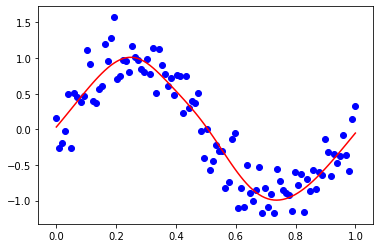

In [129]:
tester = Tester()
tester.test()